# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [3]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 704, done.
remote: Total 704 (delta 0), reused 0 (delta 0), pack-reused 704
Receiving objects: 100% (704/704), 84.47 MiB | 37.48 MiB/s, done.
Resolving deltas: 100% (313/313), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=12725 sha256=c7293bdad4ae7803ae52026f8e4165ede6164caeb5e647221494ff7942818de1
  Stored in directory: /tmp/pip-ephem-wheel-cache-8k0jykzt/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [0]:
from deepul.hw1_helper import *
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

np.random.seed(123)

In [0]:
def gather_nd(x, inds, name="gather_nd"):
    """
    x (bs, N)
    inds (bs,)
    For ith row of x, gathers the inds[i] element.
    """
    return tf.gather_nd(x, tf.expand_dims(inds, axis=-1), batch_dims=tf.rank(inds))



def train_model(model, train_data, test_data, bs, n_epochs):
    """
    Trains model on data. Returns train and test losses
    """
    # prep data
    train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
    test_dataset = tf.data.Dataset.from_tensor_slices(test_data)
    # setup for training
    train_iter = train_dataset.shuffle(bs * 2).batch(bs)
    # pre-fetch for performance
    train_iter.prefetch(bs)
    test_dataset.prefetch(bs)

    train_losses, test_losses = [], []
    for epoch in range(n_epochs):
        for batch in train_iter:
            train_loss = model.train_step(batch).numpy()
            train_losses.append(train_loss)
        test_loss = model.eval_dataset(test_dataset).numpy()
        test_losses.append(test_loss)
        print("Epoch {}".format(epoch))
    return train_losses, test_losses

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


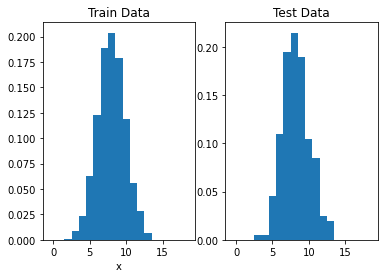

Dataset 2


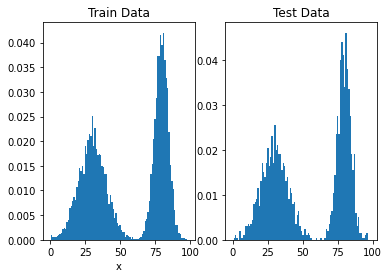

In [4]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
class SimpleModel:
    def __init__(self, d, learning_rate=0.1):
        """
        d - number of variables
        """
        self.d = d
        self.opt = tf.optimizers.Adam(learning_rate)
        self.setup_model()

    def setup_model(self):
        """
        Fill self.params as list
        """
        self.params = None

    @tf.function
    def forward(self, x):
        """
        Override to implement, computes logprobs of each input
        """
        raise NotImplementedError

    def train_step(self, X_train):
        with tf.GradientTape() as tape:
            logprob = self.eval(X_train)
        grads = tape.gradient(logprob, self.params)
        self.opt.apply_gradients(zip(grads, self.params))
        return logprob

    def eval(self, X):
        """
        Compute loss
        """
        logprobs = self.forward(X)
        return tf.reduce_mean(-logprobs)

    def eval_dataset(self, X):
        """
        only have small batches of small data in simple model so don't
        batch it here just an interface for eval
        """
        # get all data from tf.Dataset
        X = list(X)
        return self.eval(X)

    def distribution(self):
        return tf.exp(self.forward(np.arange(self.d)))

class HistModel(SimpleModel):
    def setup_model(self):
        self.thetas = tf.Variable(np.zeros(self.d))
        self.params = [self.thetas]

    @tf.function
    def forward(self, x):
        return tf.math.log(tf.gather(tf.nn.softmax(self.thetas), x))


def batch_data(data, bs):
    """
    Returns of array of batches of data of size bs, with smaller last batch
    """
    return np.array_split(data, int(len(data) / bs))


In [0]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    model = HistModel(d)
    bs = 800
    n_epochs = 30
    train_losses, test_losses = train_model(model, train_data, test_data, bs, n_epochs)
    model_probs = model.distribution().numpy()
    return train_losses, test_losses, model_probs

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Final Test Loss: 2.0760


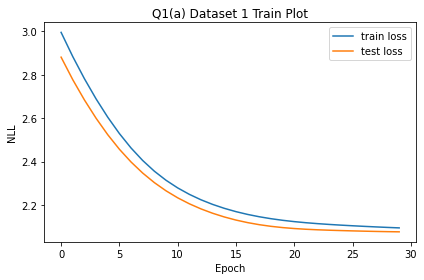

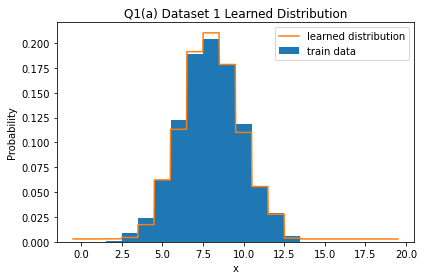

In [13]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 4.0322


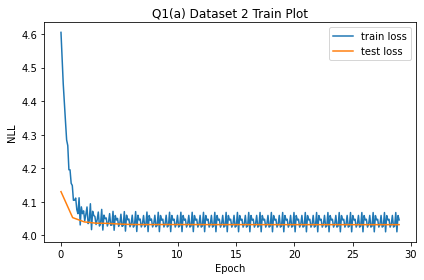

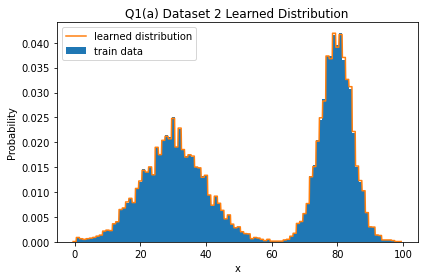

In [8]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
class DMoLModel(SimpleModel):
    def __init__(self, d, learning_rate=0.1, k=4):
        """
        k - number of logistics
        d - number of variables
        """
        self.k = k
        super(DMoLModel, self).__init__(d, learning_rate)

    def setup_model(self):
        # parameters for model
        self.pis = tf.Variable(np.random.normal(size=(self.k)), dtype=tf.float32)  # mixture components
        self.log_ss = tf.Variable(np.random.normal(size=(self.k)), dtype=tf.float32)  # std devs
        self.mus = tf.Variable((np.random.normal(size=(self.k)) * self.k), dtype=tf.float32)  # means
        self.params = [self.pis, self.mus, self.log_ss]
    
    @tf.function
    def forward(self, x):
        """
        Use logs for numerical stability
        Returns log probs of each input example
        """
        # add dim for broadcasting
        x = tf.cast(tf.expand_dims(x, 1), tf.float32)
        # get ss from log
        inv_ss = tf.exp(-self.log_ss)
        # compute logistics
        plus_term = tf.nn.sigmoid((x + 0.5 - self.mus) * inv_ss) 
        sub_term = tf.nn.sigmoid((x - 0.5 - self.mus) * inv_ss)
        logistics = plus_term - sub_term
        # corner cases 
        logistics = tf.where(x == 0, plus_term, logistics)
        logistics = tf.where(x == self.d - 1, 1-sub_term, logistics)
        # numerical stability
        log_logistics = tf.math.log(tf.maximum(logistics, 1e-12))
        # normalise mixture params
        pis = tf.nn.softmax(self.pis)
        log_pis = tf.math.log(pis)
        return tf.reduce_logsumexp(log_pis + log_logistics, axis=1)


In [0]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    model = DMoLModel(d)
    bs = 100
    n_epochs = 20
    train_losses, test_losses = train_model(model, train_data, test_data, bs, n_epochs)
    model_probs = model.distribution().numpy()
    return train_losses, test_losses, model_probs

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Final Test Loss: 2.0646


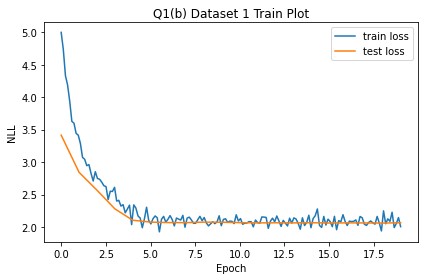

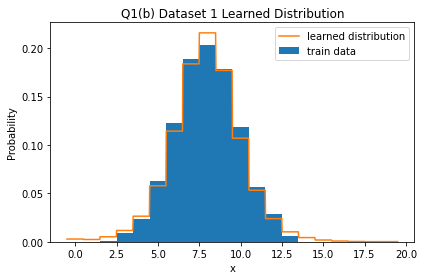

In [48]:
q1_save_results(1, 'b', q1_b)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Final Test Loss: 4.0464


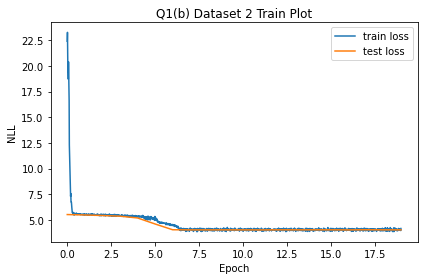

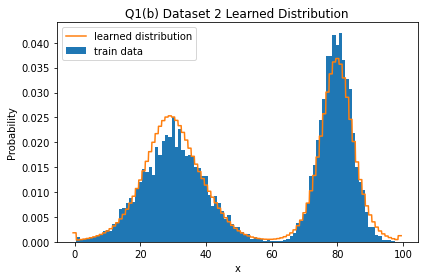

In [49]:
q1_save_results(2, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


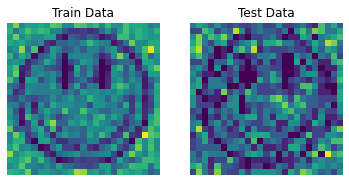

Dataset 2


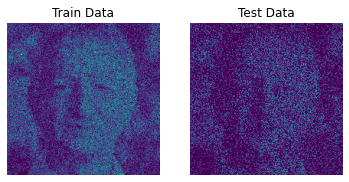

In [13]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def sample_unit_numbers(n_units, min_n, D):
    """
    D is number of random vars in the outputs of the whole model
    Sample each unit's number (the max number of inputs) from 1 to D-1
    n_units in this layer
    min_n is the lowest number to use, avoids disconnected units
    """
    # np upperbound excluded
    return np.random.randint(min_n, D, size=n_units)


def ordered_unit_numbers(n_units, min_n, D):
    """
    Ordered unit numbers for an arbitrary number of units ie. 1, 1, 1, (y times) then 2, 2, 2, (y times),
    ..., D-1, D-1, D-1 (n_units % (D-1) (leftovers) times)
    """
    rep = int(np.ceil(n_units / (D - min_n)))
    layer_units = np.repeat(np.arange(min_n, D), rep)[:n_units]
    return layer_units


def ordered_input_unit_numbers(D, N):
    """
    :param D: the number of RVs
    :param N: number of values each RV can take (because we one-hot it so each value of each RV is a single RV)
    For input and output layers as can only have D x N values
    Gives ordered units so we can sample by conditioning sequentially. ie. 1, 1, 1, (N times) then 2, 2, 2, (N times),
    ..., D, D, D (N times)
    This goes to unit number D as input and output go to D inclusive.
    """
    return np.repeat(np.arange(1, D+1), N)


def get_input_unit_numbers(D, N):
    """
    :param D: the number of RVs
    :param N: number of values each RV can take (because we one-hot it so each value of each RV is a single RV)
    :param N_aux: number of auxiliary dimensions of input we have (other than input D * N)
    So we expect inputs of shape (bs, D * N + N_aux)
    where the first D * N are ordered unit numbers repeated N times ie. 1, 1, 1, ..., D, D, D
    then for last N_aux inputs we have 1's because the aux is assumed to be conditioned on so unmasked
    """
    unit_numbers = ordered_input_unit_numbers(D, N)
    return unit_numbers


def get_output_unit_numbers(D, N):
    unit_numbers = ordered_input_unit_numbers(D, N)
    return unit_numbers


def get_aux_unit_numbers(D, N, N_aux, is_output):
    aux_unit_numbers = np.ones(N_aux)
    # aux_unit_numbers = ordered_input_unit_numbers(D, N)
    if is_output:
        return aux_unit_numbers - 1  # bc output is strict ineq
    return aux_unit_numbers


def get_mask_made(prev_unit_numbers, unit_numbers, is_output):
    """
    is_output: true if an output layer since uses different masking.
    Gets the matrix to multiply with the weights to mask connections for MADE.
    Unit numbers are the max number of inputs that the unit can be connected to (this means inputs not units in the
    previous layer, except in first hidden layer when prev layer is the inputs)
    Masking is different for output layers
    Returns mask (prev_units, units)
    """
    unit_masks = []
    if is_output:
        for prev_unit_number in prev_unit_numbers:
            unit_masks.append(unit_numbers > prev_unit_number)
    else:
        for prev_unit_number in prev_unit_numbers:
            unit_masks.append(unit_numbers >= prev_unit_number)
    return np.array(np.stack(unit_masks), dtype=np.float32)


def one_hot_inputs(x, D, N):
    """
    :param x: inputs
    :param D: the number of RVs
    :param N: number of values each RV can take (because we one-hot it so each value of each RV is a single RV)
    Converts inputs to one hot and reshapes for MADE
    :return: processed inputs (-1, N*D)
    """
    x = tf.cast(x, tf.int32)
    one_hot = tf.one_hot(x, N)
    x = tf.reshape(one_hot, (-1, N * D))
    return x


class MADELayer(tf.keras.layers.Dense):
    def __init__(self, n_units, prev_unit_numbers, D, N,
                 unit_numbers=None, activation="relu", is_output=False,
                 N_aux=0, **kwargs):
        """
        n_units is the number of units in this layer
        For MADE masking:
        prev_unit_numbers is the unit numbers (maximum number of inputs to be connected to) for prev layer
        D is number of random variables in the models output
        unit_numbers are the numbers for each unit in this layer, if None (default) to random sampling these numbers
        """
        super().__init__(n_units, activation=activation, **kwargs)
        if N_aux > 0:  # add aux to prev unit numbers
            aux_unit_numbers = get_aux_unit_numbers(D, N, N_aux, is_output)
            prev_unit_numbers = np.hstack([prev_unit_numbers, aux_unit_numbers])
        if unit_numbers is None:
            unit_numbers = ordered_unit_numbers(n_units, np.min(prev_unit_numbers), D)
        self.prev_unit_numbers = prev_unit_numbers
        self.unit_numbers = unit_numbers
        self.is_output = is_output

    def build(self, input_shape):
        super().build(input_shape)
        self.mask = get_mask_made(self.prev_unit_numbers, self.unit_numbers, self.is_output)

    def call(self, inputs, **kwargs):
        # input shape (bs, n_in + n_aux)
        # mask kernel for internal op, but then return to copy of kernel after for learning
        kernel_copy = self.kernel
        self.kernel = self.kernel * self.mask
        out = super().call(inputs)
        self.kernel = kernel_copy
        return out


class MADEModel(tf.keras.Model):
    def __init__(self, D, N, n_hidden_units, N_aux=0, dropout_rate=0.5, *args, **kwargs):
        """
        D is the number of variables.
        N is the number of values for this variable, so each of the D variables can take on
        n_hidden_units is number of units in hidden layers
        N_aux is the number of auxiliary input dimensions (default 0)
        values [0, N-1] for N possible values.
        eg. x1, x2 both [0, 9], D = 2, N = 10
        Because we extend to non-binary, multiple inputs/outputs can be for the same
        output variable (for one-hot/softmax).
        """
        super().__init__(*args, **kwargs)
        self.D = D
        self.N = N
        self.n_hidden_units = n_hidden_units
        self.N_aux = N_aux
        self.dropout_rate = dropout_rate

    def build(self, input_shape, **kwargs):
        # get ordered unit numbers for inputs with aux
        in_unit_numbers = get_input_unit_numbers(self.D, self.N)
        self.layer1 = MADELayer(self.n_hidden_units, in_unit_numbers, self.D, self.N, N_aux=self.N_aux)
        self.layer2 = MADELayer(self.n_hidden_units, self.layer1.unit_numbers, self.D, self.N, N_aux=self.N_aux)
        self.layer3 = MADELayer(self.n_hidden_units, self.layer2.unit_numbers, self.D, self.N, N_aux=self.N_aux)
        # N * D outputs
        # Ordered unit numbers for output
        out_unit_numbers = get_output_unit_numbers(self.D, self.N)
        self.output_layer = MADELayer(self.N * self.D, self.layer3.unit_numbers, self.D, self.N, N_aux=self.N_aux,
                                      unit_numbers=out_unit_numbers, activation=None, is_output=True)

    def call(self, inputs, training=None, mask=None):
        if self.N_aux > 0:
            x, aux = inputs
            x = self.layer1(tf.concat([x, aux], axis=-1))
            x = tf.keras.layers.BatchNormalization()(x, training=training)
            x = tf.keras.layers.Dropout(self.dropout_rate)(x, training=training)
            x = self.layer2(tf.concat([x, aux], axis=-1))
            x = tf.keras.layers.BatchNormalization()(x, training=training)
            x = tf.keras.layers.Dropout(self.dropout_rate)(x, training=training)
            x = self.layer3(tf.concat([x, aux], axis=-1))
            x = tf.keras.layers.BatchNormalization()(x, training=training)
            x = tf.keras.layers.Dropout(self.dropout_rate)(x, training=training)
            x = self.output_layer(tf.concat([x, aux], axis=-1))
        else:
            x = inputs
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.output_layer(x)
        x_i_outputs = tf.reshape(x, (-1, self.D, self.N))
        return x_i_outputs


class MADE:
    def __init__(self, name="MADE", N=200, D=2, one_hot=True, n_hidden_units=128, learning_rate=10e-4,
                 grad_clip=0.1):
        """
        :param name: model name
        :param N: number of values each var can take
        :param D: number of variables
        :param one_hot: if true then one-hot input before pass to model
        """
        self.name = name
        self.N = N
        self.D = D
        self.optimizer = tf.optimizers.Adam(learning_rate)
        self.one_hot = one_hot
        self.n_hidden_units = n_hidden_units
        self.setup_model()
        self.grad_clip = grad_clip

    def setup_model(self):
        """
        We have D variables which can take N values.
        So we MADE with D * N input and output units but that can only take D MADE unit numbers
        that we then separately softmax to get the D output probabilities
        """
        self.model = MADEModel(self.D, self.N, self.n_hidden_units)

    def forward_logits(self, x, training=True):
        """
        Get outputs from model (logits for softmax)
        """
        if self.one_hot:
            x = one_hot_inputs(x, self.D, self.N)
        model_outputs = self.model(x, training=training)
        return model_outputs

    @tf.function
    def forward_softmax(self, x):
        """
        Apply softmax over N values to each D variable outputs
        """
        x_i_outputs = self.forward_logits(x)
        # softmax and gather units of interest
        pxis = tf.nn.softmax(x_i_outputs, axis=-1)
        return pxis

    @tf.function
    def forward_softmax_gather(self, x):
        """
        Apply softmax over N values to each D variable outputs and gather the probs of the values in x
        """
        pxis = self.forward_softmax(x)
        x_int = tf.cast(x, tf.int32)
        pxi = gather_nd(pxis, x_int)
        # joints is product of conditionals p(x2|x1)p(x1)
        return tf.reduce_prod(pxi, axis=-1)

    @tf.function
    def loss(self, logits, labels):
        """
        MLE in nats per dimension
        Uses numerically stable TF with_logits methods
        """
        # return tf.reduce_mean(-tf_log2(probs)) / tf.cast(self.D, tf.float32)
        labels = tf.cast(labels, tf.int32)
        # labels are (bs, D), logits are (bs, D, N), we want to softmax over each D separately
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        return loss

    def train_step(self, X_train):
        with tf.GradientTape() as tape:
            logprob = self.eval(X_train)
        grads = tape.gradient(logprob, self.model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, self.grad_clip)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return logprob

    def eval(self, X, training=True):
        X_float = tf.cast(X, tf.float32)
        logits = self.forward_logits(X_float, training)
        logprob = self.loss(logits, X)
        return logprob

    def eval_dataset(self, X, bs=128):
        """
        :param X: a tf.data.Dataset
        computes eval on a tf dataset, used for test data
        returns tensor float of mean loss on dataset
        """
        n_data = 0
        weighted_sum = 0
        for batch in X.shuffle(bs * 2).batch(bs):
            n = len(batch)
            loss = self.eval(batch, training=False)
            weighted_sum += loss * n
            n_data += n
        return weighted_sum / n_data

    def distribution(self):
        """
        Only for 2D case
        Returns tensor probabilities for each x1, x2, in 0, ..., 199 as a 2D array (i, j) = p(x1=i, x2=j)
        """
        probs_flat = tf.squeeze(self.forward_softmax_gather(self.get_xs()))
        probs = tf.reshape(probs_flat, (self.N, self.N))
        return probs

    def get_xs(self):
        """
        Only for 2D case
        """
        xs = []
        for i in range(self.N):
            x = np.stack([np.ones(self.N, dtype=np.int32) * i, np.arange(self.N, dtype=np.int32)], axis=1)
            xs.append(x)
        xs = np.concatenate(xs, axis=0)
        return xs

    def sample(self, n, seed=123):
        """
        Returns n samples from model in shape (n, self.D)
        """
        # first pixel sampled unconditionally so we start with zeros input
        samples = np.zeros((n, self.D))
        for i in range(self.D):
            # assumes only one channel, input to forward_softmax is not one hot
            model_preds = self.forward_softmax(samples)
            # categorical over pixel values
            pixel_dist = tfp.distributions.Categorical(probs=model_preds[:, i])
            # update sampled pixel value
            samples[:, i] = pixel_dist.sample(1, seed=seed)
        return samples


def test_masks():
    # copy of example in paper, note these will be transposed here to match paper
    units = np.array([3, 1, 2])
    hidden_units1 = np.array([2, 1, 2, 2])
    hidden_units2 = np.array([1, 2, 2, 1])
    print(units)
    print(get_mask_made(units, hidden_units1, False).T)
    print(hidden_units1)
    print(get_mask_made(hidden_units1, hidden_units2, False).T)
    print(hidden_units1)
    # -1 because the output layer is a strict inequality
    print(get_mask_made(hidden_units2, units - 1, is_output=True).T)

In [0]:
def q2_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
    # D in my MADE is # vars, N is # values, so match this with the args (where d is # values)
    model = MADE(N=d, D=2, n_hidden_units=128, learning_rate=10e-4, grad_clip=0.1)
    bs = 128
    n_epochs = 10
    train_losses, test_losses = train_model(model, train_data, test_data, bs, n_epochs)
    distribution = model.distribution().numpy()
    return train_losses, test_losses, distribution

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Final Test Loss: 3.1853


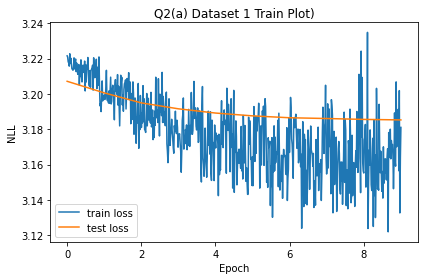

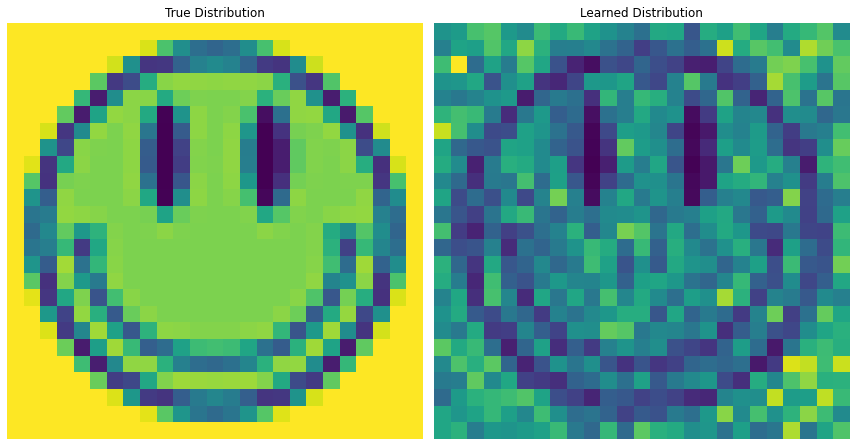

In [16]:
q2_save_results(1, 'a', q2_a)

Final Test Loss: 5.3020


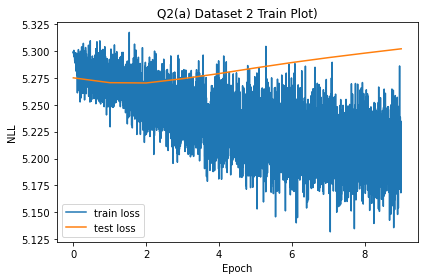

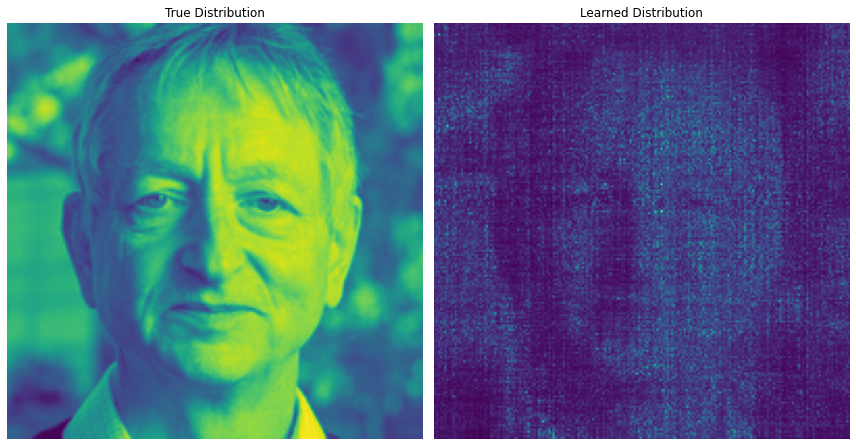

In [17]:
q2_save_results(2, 'a', q2_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

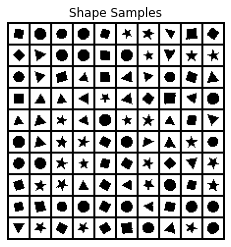

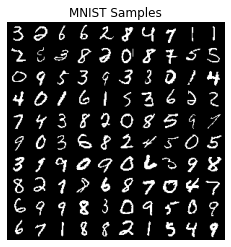

In [18]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    # N = 2, {0, 1}, D = H * W * 1 (1 channel), each pixel is var taking 2 poss values
    H, W = np.shape(train_data)[1:3]
    # flatten data
    train_data = np.reshape(train_data, (-1, H * W))
    test_data = np.reshape(test_data, (-1, H * W))
    model = MADE(D=H*W, N=2, n_hidden_units=256, learning_rate=10e-4, grad_clip=0.05)
    bs = 128
    n_epochs = 10
    train_losses, test_losses = train_model(model, train_data, test_data, bs, n_epochs)
    samples = model.sample(100)
    samples = np.reshape(samples, (100, H, W, 1))
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.0656


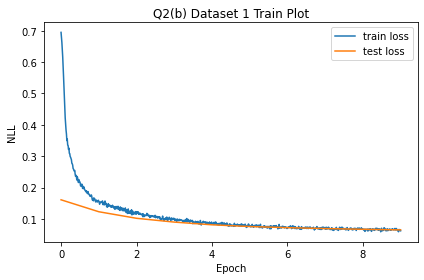

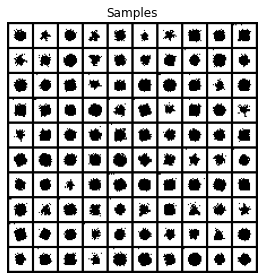

In [20]:
q2_save_results(1, 'b', q2_b)

Final Test Loss: 0.1943


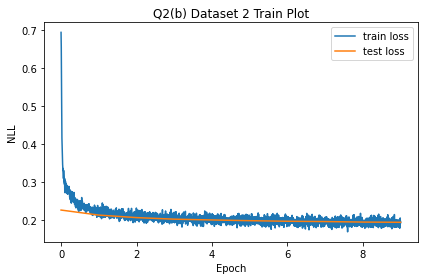

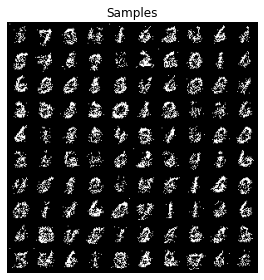

In [21]:
q2_save_results(2, 'b', q2_b)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
"""
PixelCNN
"""

def get_pixelcnn_mask(kernel_size, in_channels, out_channels, isTypeA, n_channels=3, factorised=True):
    """
    Masks are repeated in groups with modulo if channel in or out != n_channels so if
    5 channels then it's R, R, G, G, B etc.
    This is so that when reshaping to (H, W, #channels, #values) we get each channel's values aligning
    For RGB channel taking N values case it's R1, R2, ... RN, G1, G2, ... GN, B1, B2, ... BN which reshapes to
    [R1, R2, ... RN], [G1, G2, ... GN], [B1, B2, ... BN]

    raster ordering on conditioning mask.

    kernel_size: size N of filter N x N
    in_channels: number of channels/filters in
    out_channels: number of channels/filters out
    n_channels: number of channels for masking eg. 3 for RGB masks
    isTypeA: bool, true if type A mask, otherwise type B mask used.
        Type A takes context and previous channels (but not its own channel)
        Type B takes context, prev channels and connected to own channel.
    factorised: bool, if True then we factorise over channels, ie. probs treated independently P(r)p(g)p(b)
        so mask type A all have centre off and B all have it on.
        Otherwise the full joint probs are used p(r)p(g|r)p(b|r,g) which requires conditioning on previous channels
        and A and B masks are different for each channel to allow this.

    Returns masks of shape (kernel_size, kernel_size, # in channels, # out channels)
    """
    channel_masks = np.ones((kernel_size, kernel_size, n_channels, n_channels), dtype=np.int32)
    centre = kernel_size // 2
    # bottom rows 0s
    channel_masks[centre+1:, :, :, :] = 0
    # right of centre on centre row 0s
    channel_masks[centre:, centre+1:, :, :] = 0
    # deal with centre based on mask "way": factorised or full
    # rows are channels in prev layer, columns are channels in this layer
    if factorised:
        if isTypeA:
            channel_masks[centre, centre, :, :] = 0
    else:
        # centre depends on mask type A or B
        k = 0 if isTypeA else 1
        # reverse i and j to get RGB ordering (other way would be BGR)
        i, j = np.triu_indices(n_channels, k)
        channel_masks[centre, centre, j, i] = 0.

    # we use repeat not tile because this keeps the correct ordering we need
    tile_shape = (int(np.ceil(in_channels / n_channels)), int(np.ceil(out_channels / n_channels)))
    masks = np.repeat(channel_masks, tile_shape[0], axis=2)
    masks = np.repeat(masks, tile_shape[1], axis=3)
    # tile the masks to potentially more than needed, then retrieve the number of channels wanted
    return masks[:, :, :in_channels, :out_channels]


class MaskedCNN(tf.keras.layers.Conv2D):
    def __init__(self, n_filters, kernel_size, isTypeA, factorised, activation=None, **kwargs):
        """
        n_filters and kernel_size for conv layer
        isTypeA for mask type
        """
        assert isinstance(kernel_size, int), "Masked CNN requires square n x n kernel"
        super(MaskedCNN, self).__init__(n_filters, kernel_size, padding="SAME",
                                        activation=activation, **kwargs)
        self.isTypeA = isTypeA
        self.factorised = factorised

    def build(self, input_shape):
        super().build(input_shape)
        (_, _, in_channels, out_channels) = self.kernel.shape
        self.mask = get_pixelcnn_mask(self.kernel_size[0], in_channels, out_channels, self.isTypeA,
                                      factorised=self.factorised)

    def call(self, inputs):
        # mask kernel for internal conv op, but then return to copy of kernel after for learning
        kernel_copy = self.kernel
        self.kernel = self.kernel * self.mask
        out = super().call(inputs)
        self.kernel = kernel_copy
        return out


class MaskedResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters, factorised):
        super().__init__()
        self.n_filters = n_filters
        self.factorised = factorised

    def build(self, input_shape):
        # 1x1 relu filter, then 3x3 then 1x1
        self.layer1 = MaskedCNN(self.n_filters, 1, False, self.factorised)
        self.layer2 = MaskedCNN(self.n_filters, 7, False, self.factorised)
        self.layer3 = MaskedCNN(self.n_filters * 2, 1, False, self.factorised)

    def call(self, inputs):
        """
        x is the inputs, [image, (cx, cy)]
        """
        # other layers take img and cur pixel location
        x = tf.keras.layers.ReLU()(inputs)
        x = self.layer1(x)
        x = tf.keras.layers.ReLU()(x)
        x = self.layer2(x)
        x = tf.keras.layers.ReLU()(x)
        x = self.layer3(x)
        return inputs + x


class PixelCNNModel(tf.keras.Model):
    """
    Returns logits for softmax (N, h*w, c, n_vals)
    """

    def __init__(self, H, W, C, N, factorised, n_filters, n_res, flat=False, *args, **kwargs):
        """
        :param N: number of values each var can take on
        :param flat: whether to keep flat or reshape each value for each channel variable
            if true then (bs, H, W, C * N) otherwise reshapes into logits (bs, H, W, C, N)
        """
        super().__init__(*args, **kwargs)
        self.N = N
        self.H = H
        self.W = W
        self.C = C
        self.n_filters = n_filters
        self.n_res = n_res
        self.flat = flat
        self.factorised = factorised

    def build(self, input_shape, **kwargs):
        self.layer1 = MaskedCNN(self.n_filters * 2, 7, True, self.factorised)
        self.res_layers = [MaskedResidualBlock(self.n_filters, self.factorised) for _ in range(self.n_res)]
        # want ReLU applied first as per paper
        self.relu_conv1x1 = [tf.keras.layers.ReLU(),
                             MaskedCNN(self.n_filters, 1, False, self.factorised)]
        self.output_conv = [tf.keras.layers.ReLU(),
                            MaskedCNN(self.N * self.C, 1, False, self.factorised)]

    def call(self, inputs, training=None, mask=None):
        img = tf.cast(inputs, tf.float32)
        x = self.layer1(img)
        for layer in self.res_layers:
            x = layer(x)
        for layer in self.relu_conv1x1:
            x = layer(x)
        for layer in self.output_conv:
            x = layer(x)
        if not self.flat:
            x = tf.reshape(x, (-1, self.H, self.W, self.C, self.N))
        return x


class PixelCNN:
    def __init__(self, H=28, W=28, C=3, n_vals=4, learning_rate=10e-4, grad_clip=1,
                 n_filters=128, n_res=9, factorised=True):
        """
        H, W, C image shape: height, width, channels
        n_vals the number of values each channel can take on
        factorised: bool, if True then we factorise over channels, ie. probs treated independently P(r)p(g)p(b)
            so mask type A all have centre off and B all have it on.
            Otherwise the full joint probs are used p(r)p(g|r)p(b|r,g) which requires conditioning on previous channels
            and A and B masks are different for each channel to allow this.
        n_filters - number of filters each conv layer
        n_res - number of residual layers to have
        """
        self.name = "PixelCNN"
        self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        self.H = H
        self.W = W
        self.C = C
        self.n_vals = n_vals
        self.factorised = factorised
        self.n_filters = n_filters
        self.n_res = n_res
        self.learning_rate = learning_rate
        self.grad_clip = grad_clip
        self.setup_model()

    def __str__(self):
        return "Name: {}\nFactorised: {}\nLearning rate: {}\n".format(self.name,
                                                                    self.factorised, self.learning_rate)

    def setup_model(self):
        self.model = PixelCNNModel(self.H, self.W, self.C, self.n_vals, 
                                   self.factorised, self.n_filters, self.n_res)

    @tf.function
    def loss(self, labels, logits):
        """
        probs are outputs of forward model, a probability for each image (N, )
        Returns mean *negative* log prob (likelihood) over x (a scalar)
        Since single dimension predicted each forward pass, logprob in nats per dimension
        """
        labels = tf.cast(labels, tf.int32)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        return loss

    @tf.function
    def forward_logits(self, x):
        """
        Forward pass returning full (flat) logits from model (N, H * W, C, N_V)
        where N_V is number of values each channel can take.
        """
        # scale to [-1, 1]
        x = (2 * x / self.n_vals) - 1
        logits = self.model(x)
        return logits

    @tf.function
    def forward_softmax(self, x):
        """
        Fwd pass retuning softmax values in image shape (N, H, W, C, N_V)
        """
        logits = self.forward_logits(x)
        # seems to be numerical precision errors using float32
        logits_64 = tf.cast(logits, tf.float64)
        probs = tf.nn.softmax(logits_64, axis=-1)
        return probs

    def train_step(self, X_train):
        """
        Takes batch of data X_train
        returns logprob numpy
        """
        with tf.GradientTape() as tape:
            logprob = self.eval(X_train)
        grads = tape.gradient(logprob, self.model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, self.grad_clip)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return logprob

    def eval_dataset(self, X, bs=64):
        """
        :param X: a tf.data.Dataset
        computes eval on a tf dataset
        returns float of mean loss on dataset
        """
        n_data = 0
        weighted_sum = 0
        for batch in X.shuffle(bs * 2).batch(bs):
            n = len(batch)
            loss = self.eval(batch)
            weighted_sum += loss * n
            n_data += n
        return weighted_sum / n_data

    @tf.function
    def eval(self, X):
        """
        Runs forward pass and loss
        :param X: input images batch
        :return: loss tensor
        """
        logits = self.forward_logits(X)
        loss = self.loss(X, logits)
        return loss

    def sample(self, n, seed=123):
        """
        Generation is done from blank image (all 0s), we then sample R channel
        of first pixel, then G then B and then for second pixel etc.
        We batch this for efficiency.
        """
        images = np.zeros((n, self.H, self.W, self.C))
        # start with random values for first channel of first pixel (this is updated in first pass)
        images[:, 0, 0, 0] = np.random.choice(self.n_vals, n)
        for h in range(self.H):
            for w in range(self.W):
                # if factorised over channels then only need one fwd pass
                if self.factorised:
                    model_preds = self.forward_softmax(images)
                    # categorical over pixel values
                    pixel_dist = tfp.distributions.Categorical(probs=model_preds[:, h, w])
                    images[:, h, w] = pixel_dist.sample(1, seed=seed)
                # o/w we need to condition on prev channels
                else:
                    for c in range(self.C):
                        model_preds = self.forward_softmax(images)
                        # categorical over pixel values
                        pixel_dist = tfp.distributions.Categorical(probs=model_preds[:, h, w, c])
                        images[:, h, w, c] = pixel_dist.sample(1, seed=seed)
        return images

In [0]:
def q3_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    H, W = image_shape
    # 2 vals bc binary
    model = PixelCNN(H=H, W=W, C=1, n_vals=2, learning_rate=10e-4, n_filters=64, n_res=5)
    bs = 128
    n_epochs = 10
    train_losses, test_losses = train_model(model, train_data, test_data, bs, n_epochs)
    samples = model.sample(100)
    samples = np.reshape(samples, (100, H, W, 1))
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Final Test Loss: 0.0395


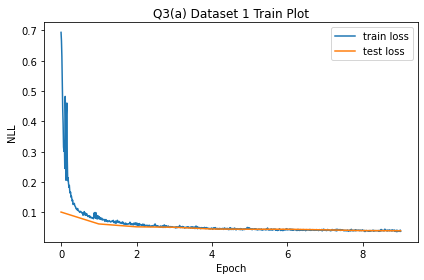

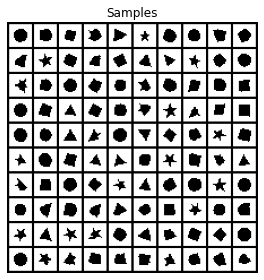

In [68]:
q3a_save_results(1, q3_a)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Final Test Loss: 0.0743


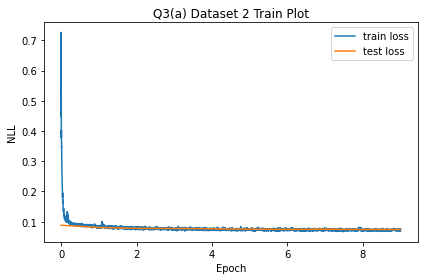

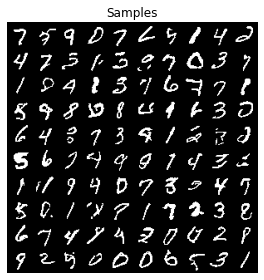

In [29]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

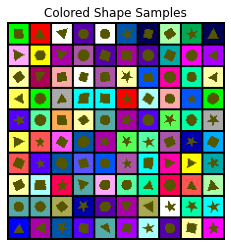

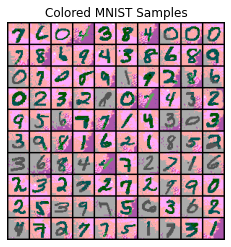

In [30]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    H, W, C = image_shape
    N = 4
    model = PixelCNN(H=H, W=W, C=C, n_vals=N, learning_rate=10e-4, n_filters=128,
                     factorised=True)
    bs = 128
    n_epochs = 10
    train_losses, test_losses = train_model(model, train_data, test_data, bs, n_epochs)
    samples = model.sample(100)
    samples = np.reshape(samples, (100, H, W, C))
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results



Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Final Test Loss: 0.0474


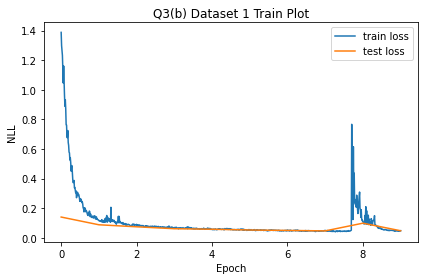

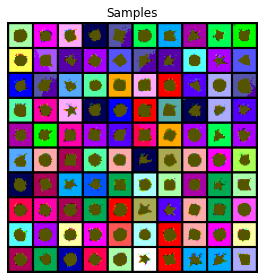

In [32]:
q3bc_save_results(1, 'b', q3_b)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Final Test Loss: 0.0800


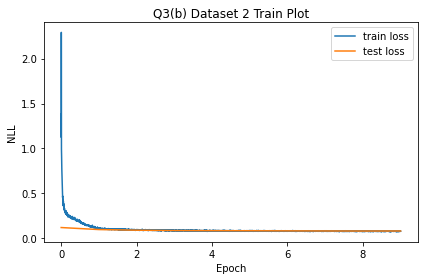

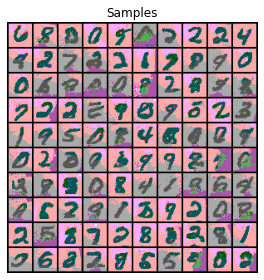

In [33]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def q3_c(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    H, W, C = image_shape
    N = 4
    # factorised flag makes autoregressive across channels
    model = PixelCNN(H=H, W=W, C=C, n_vals=N, learning_rate=10e-4, n_filters=128,
                     factorised=False)
    bs = 128
    n_epochs = 10
    train_losses, test_losses = train_model(model, train_data, test_data, bs, n_epochs)
    samples = model.sample(100)
    samples = np.reshape(samples, (100, H, W, C))
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Final Test Loss: 0.0310


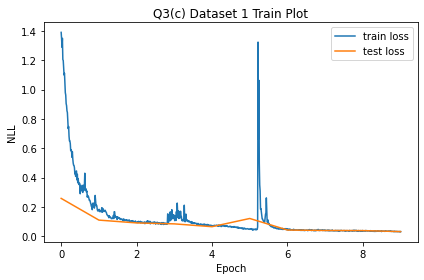

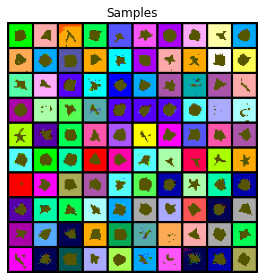

In [42]:
q3bc_save_results(1, 'c', q3_c)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Final Test Loss: 0.0317


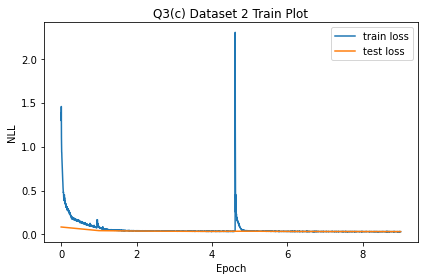

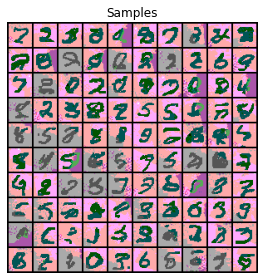

In [41]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
"""
Conditional PixelCNN
"""
# can't subclass Conv2D bc tuple input raises error
class ConditionalMaskedCNN(tf.keras.layers.Layer):
    def __init__(self, NC, n_filters, kernel_size, isTypeA, factorised, 
                 activation="relu", **kwargs):
        """
        n_filters and kernel_size for conv layer
        isTypeA for mask type
        """
        self.conv = tf.keras.layers.Conv2D(n_filters, kernel_size, padding="SAME",
                                        activation=activation, **kwargs)
        self.isTypeA = isTypeA
        self.NC = NC
        self.factorised = factorised
        super(ConditionalMaskedCNN, self).__init__()

    def build(self, input_shape):
        # first is image shape for conv layer
        self.conv.build(input_shape[0])
        (_, _, in_channels, out_channels) = self.conv.kernel.shape
        self.mask = get_pixelcnn_mask(self.conv.kernel_size[0], in_channels, out_channels, self.isTypeA,
                                      factorised=self.factorised)
        self.class_bias = self.add_weight(shape=(self.NC, self.conv.filters),
                             initializer='random_normal',
                             trainable=True)

    def call(self, inputs):
        """
        inputs = tuple of datasets (X, Y)
        x is the input from prev layer, y is one-hot encoding of class label
        x (bs, H_l, W_l, C_l), y (bs, # classes)
        """
        x, y = inputs
        # mask kernel for internal conv op, but then return to copy of kernel after for learning
        kernel_copy = self.conv.kernel
        self.conv.kernel = self.conv.kernel * self.mask
        # call conv and bias
        out = self.conv(x)
        self.conv.kernel = kernel_copy
        # add class conditional bias
        # transpose to bcast the addition
        out = tf.transpose(out, [1,2,0,3]) + tf.matmul(y, self.class_bias)
        # return to shape
        out = tf.transpose(out, [2,0,1,3])
        return out


class ConditionalPixelCNNModel(tf.keras.Model):
    """
    Returns logits for softmax (N, h*w, c, n_vals)
    """

    def __init__(self, H, W, C, N, NC, factorised, n_filters, n_res, 
                 flat=False, *args, **kwargs):
        """
        :param N: number of values each var can take on
        :param flat: whether to keep flat or reshape each value for each channel variable
            if true then (bs, H, W, C * N) otherwise reshapes into logits (bs, H, W, C, N)
        NC - number of classes
        """
        super().__init__(*args, **kwargs)
        self.N = N
        self.H = H
        self.W = W
        self.C = C
        self.NC = NC
        self.n_filters = n_filters
        self.n_res = n_res
        self.flat = flat
        self.factorised = factorised

    def build(self, input_shape, **kwargs):
        self.layer1 = ConditionalMaskedCNN(self.NC, self.n_filters * 2, 7, True, self.factorised)
        self.hidden_layers = [ConditionalMaskedCNN(self.NC, self.n_filters, 7, False, self.factorised) for _ in range(6)]
        self.output_layers = [ConditionalMaskedCNN(self.NC, self.N * self.C, 1, False, self.factorised) for _ in range(2)]

    def call(self, inputs, training=None, mask=None):
        """
        inputs = dataset of tuples (x, y) where
        x is input image and y is class label
        x is images (bs, H, W, C)
        y is class labels (bs,)
        """
        x, y = inputs
        img = tf.cast(x, tf.float32)
        # one-hot y
        y = tf.one_hot(y, self.NC)
        x = self.layer1((img, y))
        for layer in self.hidden_layers:
            x = layer((x, y))
        for layer in self.output_layers:
            x = layer((x, y))
        if not self.flat:
            x = tf.reshape(x, (-1, self.H, self.W, self.C, self.N))
        return x


class ConditionalPixelCNN(PixelCNN):
    def __init__(self, NC, H=28, W=28, C=3, n_vals=4, learning_rate=10e-4, grad_clip=1,
                 n_filters=128, n_res=9, factorised=True):
        """
        Note this takes 
        inputs = dataset of tuples (x, y) where
        x is input image and y is cValueError: Layer conditional_masked_cnn_6 expects 1 inputs, but it received 2 input tensorslass label
        x is images (bs, H, W, C)
        y is class labels (bs,)

        NC - number of classes
        H, W, C image shape: height, width, channels
        n_vals the number of values each channel can take on
        factorised: bool, if True then we factorise over channels, ie. probs treated independently P(r)p(g)p(b)
            so mask type A all have centre off and B all have it on.
            Otherwise the full joint probs are used p(r)p(g|r)p(b|r,g) which requires conditioning on previous channels
            and A and B masks are different for each channel to allow this.
        n_filters - number of filters each conv layer
        n_res - number of residual layers to have
        """
        self.NC = NC
        super(ConditionalPixelCNN, self).__init__(H, W, C, n_vals, learning_rate, grad_clip,
                                                  n_filters, n_res, factorised)
        self.name = "ConditionalPixelCNN"

    def setup_model(self):
        self.model = ConditionalPixelCNNModel(self.H, self.W, self.C, self.n_vals,
                                              self.NC, self.factorised, self.n_filters, self.n_res)
    # not tf.function bc not tensor input -> retracing
    def forward_logits(self, inputs):
        """
        inputs = dataset of tuples (x, y) where
        x is input image and y is class label
        x is images (bs, H, W, C)
        y is class labels (bs,)
        Forward pass returning full (flat) logits from model (N, H * W, C, N_V)
        where N_V is number of values each channel can take.
        """
        x, y = inputs
        # scale only x to [-1, 1]
        x = (2 * x / self.n_vals) - 1
        logits = self.model((x, y))
        return logits

    def loss(self, inputs, logits):
        """
        probs are outputs of forward model, a probability for each image (N, )
        Returns mean *negative* log prob (likelihood) over x (a scalar)
        Since single dimension predicted each forward pass, logprob in nats per dimension
        """
        x, _ = inputs
        # use image (not class labels) as generative model labels
        labels = tf.cast(x, tf.int32)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        return loss

    def sample(self, n, seed=123):
        """
        Generation is done from blank image (all 0s), we then sample R channel
        of first pixel, then G then B and then for second pixel etc.
        We batch this for efficiency.
        """
        images = np.zeros((n, self.H, self.W, self.C))
        # class labels for samples 1, 2, 3, ... NC, 1, 2, 3, ..., NC
        # repeated as many times to get close to even number of samples per class
        rep = int(np.ceil(n / self.NC))
        classes = np.tile(np.arange(self.NC), rep)[:n]
        # start with random values for first channel of first pixel (this is updated in first pass)
        images[:, 0, 0, 0] = np.random.choice(self.n_vals, n)
        for h in range(self.H):
            for w in range(self.W):
                # if factorised over channels then only need one fwd pass
                if self.factorised:
                    model_preds = self.forward_softmax((images, classes))
                    # categorical over pixel values
                    pixel_dist = tfp.distributions.Categorical(probs=model_preds[:, h, w])
                    images[:, h, w] = pixel_dist.sample(1, seed=seed)
                # o/w we need to condition on prev channels
                else:
                    for c in range(self.C):
                        model_preds = self.forward_softmax((images, classes))
                        # categorical over pixel values
                        pixel_dist = tfp.distributions.Categorical(probs=model_preds[:, h, w, c])
                        images[:, h, w, c] = pixel_dist.sample(1, seed=seed)
        return images

In [0]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
    """
    train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
    train_labels: A (n_train,) numpy array of class labels
    test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
    test_labels: A (n_test,) numpy array of class labels
    image_shape: (H, W), height and width
    n_classes: number of classes (4 or 10)
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
        where an even number of images of each class are sampled with 100 total
    """
    H, W = image_shape
    C = 1
    N = 2
    # factorised flag makes autoregressive across channels
    model = ConditionalPixelCNN(n_classes, H=H, W=W, C=C, n_vals=N, 
                                learning_rate=10e-4, grad_clip=1, n_filters=72)
    bs = 128
    n_epochs = 15 if dset_id == 1 else 10
    train_losses, test_losses = train_model(model, (train_data, train_labels), (test_data, test_labels), bs, n_epochs)
    samples = model.sample(100)
    samples = np.reshape(samples, (100, H, W, C))
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_d`, execute the cells below to visualize and save your results



Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Final Test Loss: 0.0470


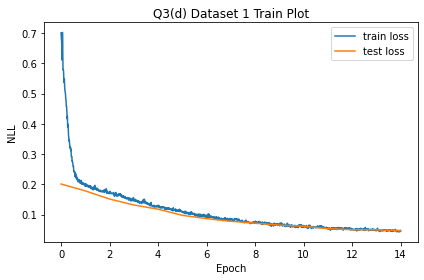

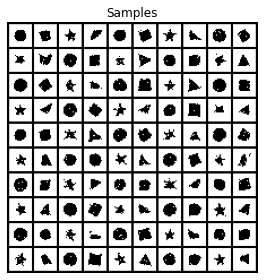

In [26]:
q3d_save_results(1, q3_d)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Final Test Loss: 0.0720


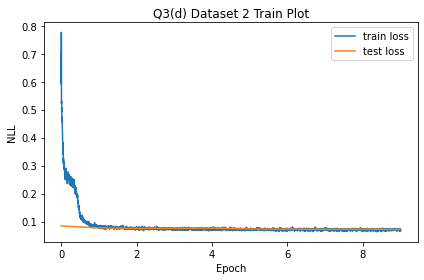

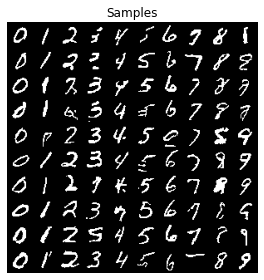

In [18]:
q3d_save_results(2, q3_d)

# Question 4: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def q4_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_a`, execute the cells below to visualize and save your results



In [0]:
q4a_save_results(q4_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def q4_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [0]:
q4b_save_results(q4_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [0]:
def q4_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_c`, execute the cells below to visualize and save your results



In [0]:
q4c_save_results(q4_c)